# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 6</span>

## Index

- [Equilibration](#section-1)
- [Simulation vs Exact Solution](#section-2)
    - [Internal Energy](#subsection-2-1)
    - [Head Capacity](#subsection-2-2)
    - [Magnetization](#subsection-2-3)
    - [Magnetic Susceptibility](#subsection-2-4)


## Exercise 06.1

Complete the NSL_simulator code to simulate a 1D Ising model with the Gibbs sampling algorithm (the Metropolis algorithm is already implemented) to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$. Verify the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- <span style="color:red">Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties</span> obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with <span style="color:blue">both sampling methods, Metropolis and Gibbs</span>.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

<a id="section-1"></a>
# Equilibration

“Equilibrium” means that the average probability of finding our system in any particular state $µ$ is proportional to the Boltzmann weight $p(\mu)$ of that state, i.e., we are correctly sampling $p(\mu)$

`input.ising`:
```bash
SIMULATION_TYPE        2/3    1.0   0.0
RESTART                0
TEMP                   1.0/3.0
NPART                  50
RHO                    1.0
R_CUT                  0.0
DELTA                  0.0
NBLOCKS                10000
NSTEPS                 1
```

for magnetization:
```bash
SIMULATION_TYPE        2/3    1.0   0.02
```

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

J = 1.0
Ns = 50

# Internal energy
def U(T):
    beta = 1/T    
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    return -J*( th + ch*thN )/( 1 + thN )

# Specific heat
def heat(T):
    beta = 1/T
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    return ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# Magnetization
def M(T,h):
        b = 1/T
        l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
        l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
        Z = l1**Ns + l2**Ns
        return (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
                + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# Magnetic susceptibility
def X(T):
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    return beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

# Function to calculate probability from chi-square value and degrees of freedom
def chi2_probability(chi2_red, df):
    return 1 - chi2.cdf(chi2_red*df, df)

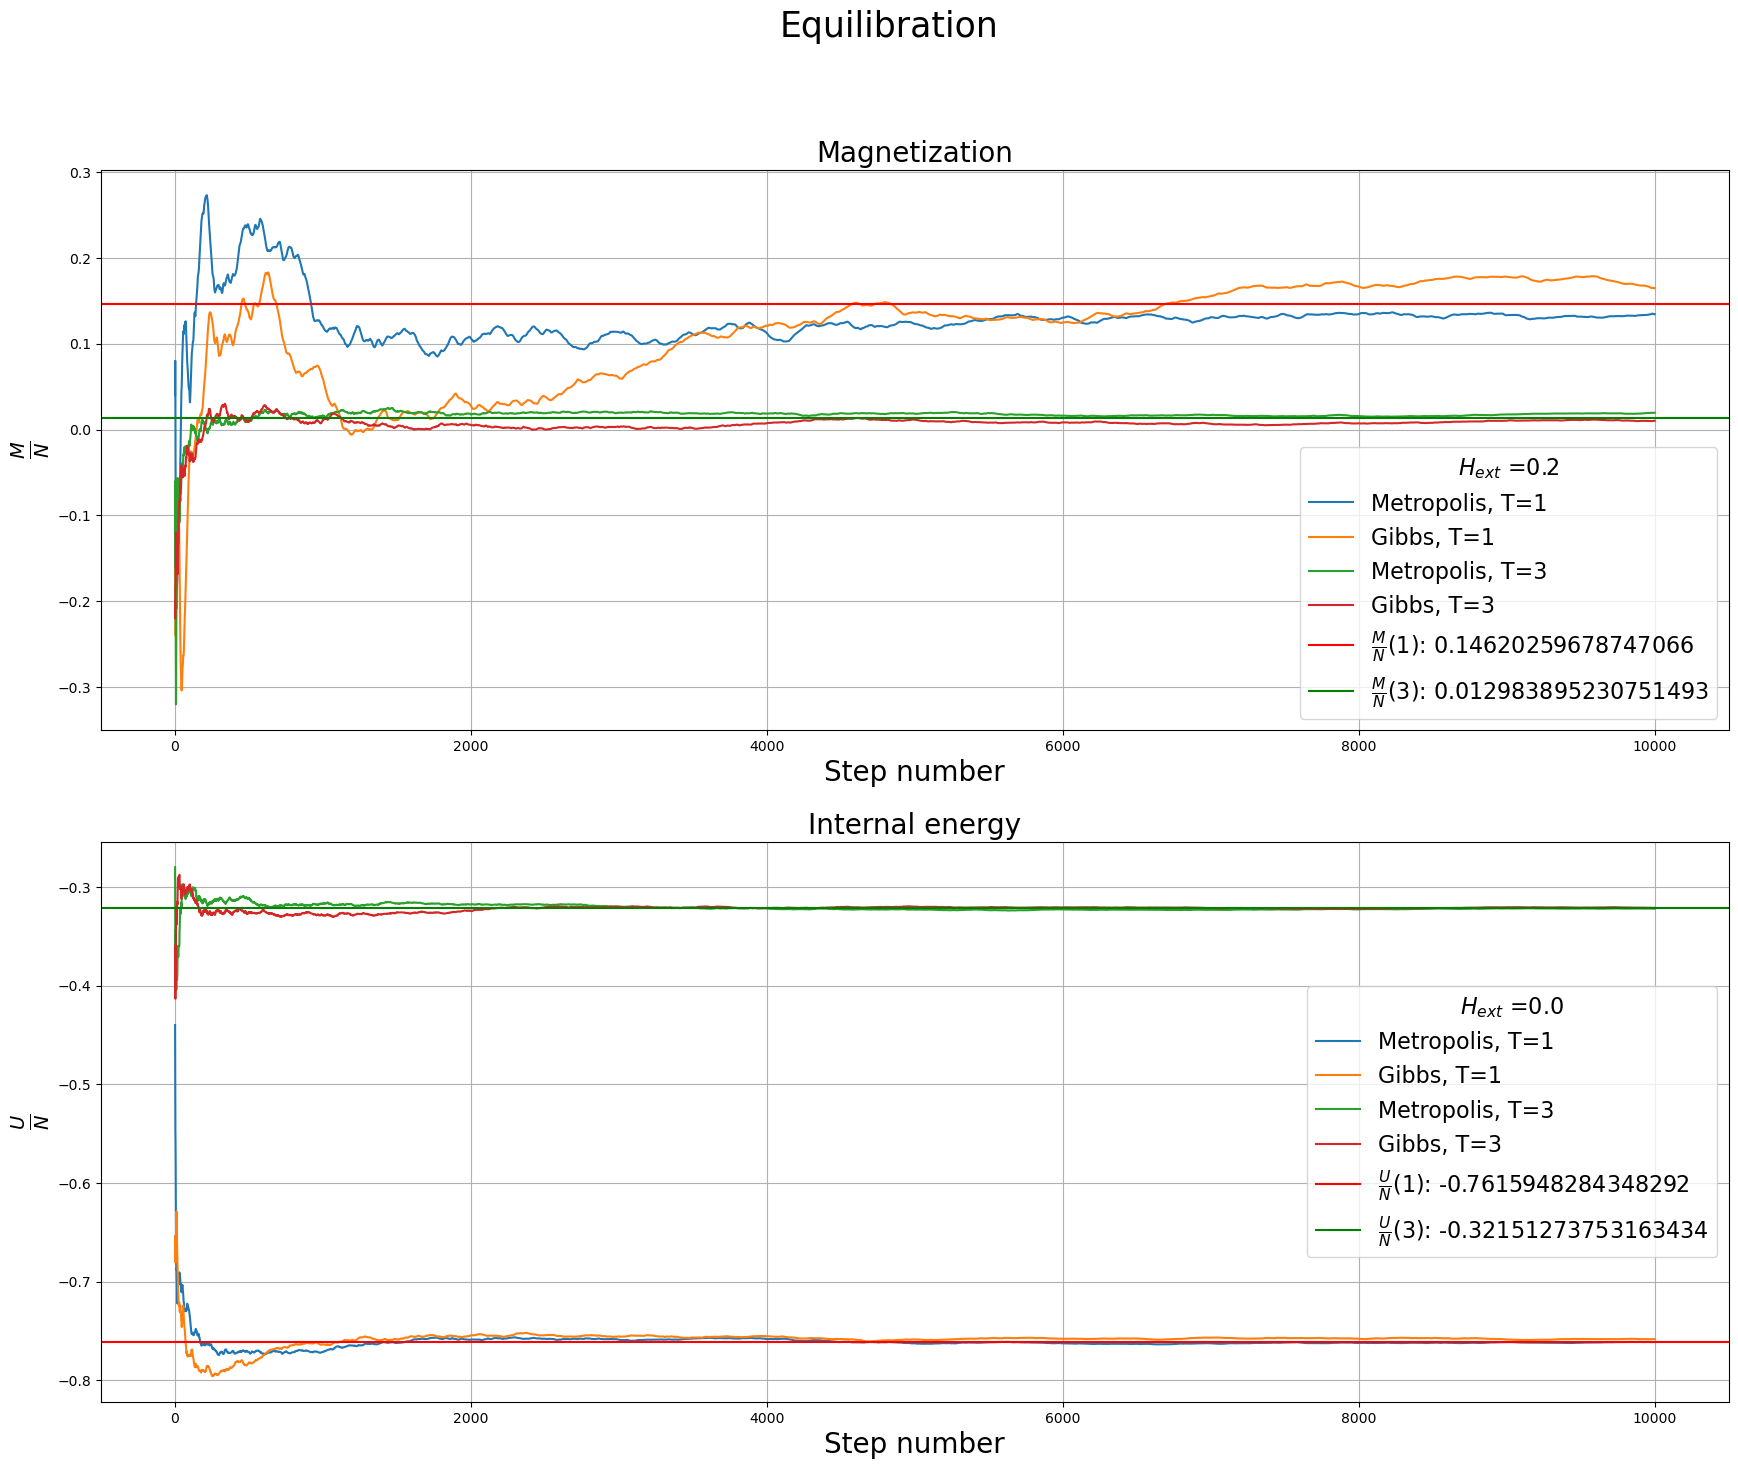

In [14]:
N = 10000

titles = ["Magnetization","Internal energy","Specific heat","Susceptibility"]
prop = ["magnetization","total_energy","specific_heat","susceptibility"]
units = [r"$\frac{M}{N}$",r"$\frac{U}{N}$",r"$\frac{C}{N}$",r"$\frac{\chi}{N}$"]
methods = ["Metropolis","Gibbs"]
target = [M(1,0.02), U(1)]
target3 = [M(3,0.02), U(3)]
plt.figure(figsize=(21,16))
plt.suptitle("Equilibration", fontsize = 25)

col= 2 #1= instant value, 2= progressive mean value
# the measure of specific heat and susceptibility can't be measured instantly
for i in range(0,2):

    plt.subplot(2,1,i+1) # 2 rows, 1 column, i-th plot
    x = np.arange(N)+1    # Number of blocks
    y1 = np.loadtxt("../DATA/Equilibration/Metropolis/T1/"+prop[i]+".dat", usecols=(col),skiprows=1, unpack='true')
    y2 = np.loadtxt("../DATA/Equilibration/GIBBS/T1/"+prop[i]+".dat", usecols=(col),skiprows=1, unpack='true')
    y3 = np.loadtxt("../DATA/Equilibration/Metropolis/T3/"+prop[i]+".dat", usecols=(col),skiprows=1, unpack='true')
    y4 = np.loadtxt("../DATA/Equilibration/GIBBS/T3/"+prop[i]+".dat", usecols=(col),skiprows=1, unpack='true')
    plt.plot(x, y1[:N], marker=None, label= methods[0]+", T=1")
    plt.plot(x, y2[:N], marker=None, label= methods[1]+", T=1")
    plt.plot(x, y3[:N], marker=None, label= methods[0]+", T=3")
    plt.plot(x, y4[:N], marker=None, label= methods[1]+", T=3")
    plt.title(titles[i], fontsize = 20)
    plt.ylabel(units[i], fontsize = 20)
    plt.xlabel('Step number', fontsize = 20)
    plt.axhline(y=target[i], color ="r", label = units[i]+"(1): "+str(target[i]))
    plt.axhline(y=target3[i], color ="g", label = units[i]+"(3): "+str(target3[i]))
    plt.grid()
    plt.legend(title= r"$H_{ext}$ ="+ str(0.2*(1-i)), fontsize = 16,title_fontsize= 16)
plt.show()

Since the simulations run quickly, i decided to skip 4000 steps and call it quit for termalization. Then start taking the measurement for magnetization, total energy, heat capacity and magnetic susceptibility.

<a id="section-2"></a>
# Simulation vs Exact Solution

```bash
SIMULATION_TYPE        2/3    1.0     0.0/0.02
RESTART                0
TEMP                   0.5-3.0
NPART                  50
RHO                    1.0
R_CUT                  0.0
DELTA                  0.0
NBLOCKS                20
NSTEPS                 20000 / 200000
ENDINPUT
```
I chose to run the simulation with $2 \cdot 10^5$ steps per block to measure the quantities susceptibility, specific heat and internal energy with Metropolis because the $\chi^2$ test gave unsatisfactory condidence level (below $5\%$).
I did the same thing for Gibbs for to compare better the two algorithms.
By multiplying by a factor of $10$ the number of steps, the error associated decreased by roughly a factor of $3$ in accordance with the Central Limit Theorem.


While for magnetization i was satisfied with $2 \cdot 10^4$ steps per block (for h= 0.02 as required is all good). From the graph it can be seen that the simulated values follow qualitatively and quantitatively the values obtained from the exact solution.


`Metropolis.py` is a Python script that automates the process of running simulations using the Metropolis algorithm and extracting results from the outputs. Here's a summary of its functionality:

1. **Input File Modification**: The script modifies an input file (`input.ising`) to update simulation parameters such as temperature (`TEMP`) and external magnetic field (`h`) based on the properties being calculated.

2. **Simulation Execution**: It executes a C++ program (`simulator.exe`) using the modified input file as an argument.

3. **Data Extraction**: After each simulation, the script extracts the last line from each output file (`total_energy.dat`, `specific_heat.dat`, `susceptibility.dat`, and `magnetization.dat`) in the directory `../OUTPUT` and writes it to corresponding destination (`../DATA/Ising/Metropolis`). Additionally, it modifies the first column of the extracted line to include the temperature (`TEMP`) value.

6. **Two Simulation Runs**: The script performs two separate simulation runs: one for properties with `h=0.0` (total energy, specific heat, and susceptibility) and another for magnetization with `h=0.02`.

`Gibbs.py` does the same thing but using Gibbs sampling

File in `../DATA/ISING/Metropolis` has the following format: \
"Temperature"   "Value from last block" "Progressive mean"  "error"

<a id="subsection-2-1"></a>
## Internal Energy

In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$:

- the **Internal Energy** per spin (with $h=0$):

$$
\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}
= -\frac{1}{N}\frac{\partial \ln Z}{\partial \beta}
\underset{h=0}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

Confidence level for Metropolis:  0.685
Confidence level for Gibbs:  0.673


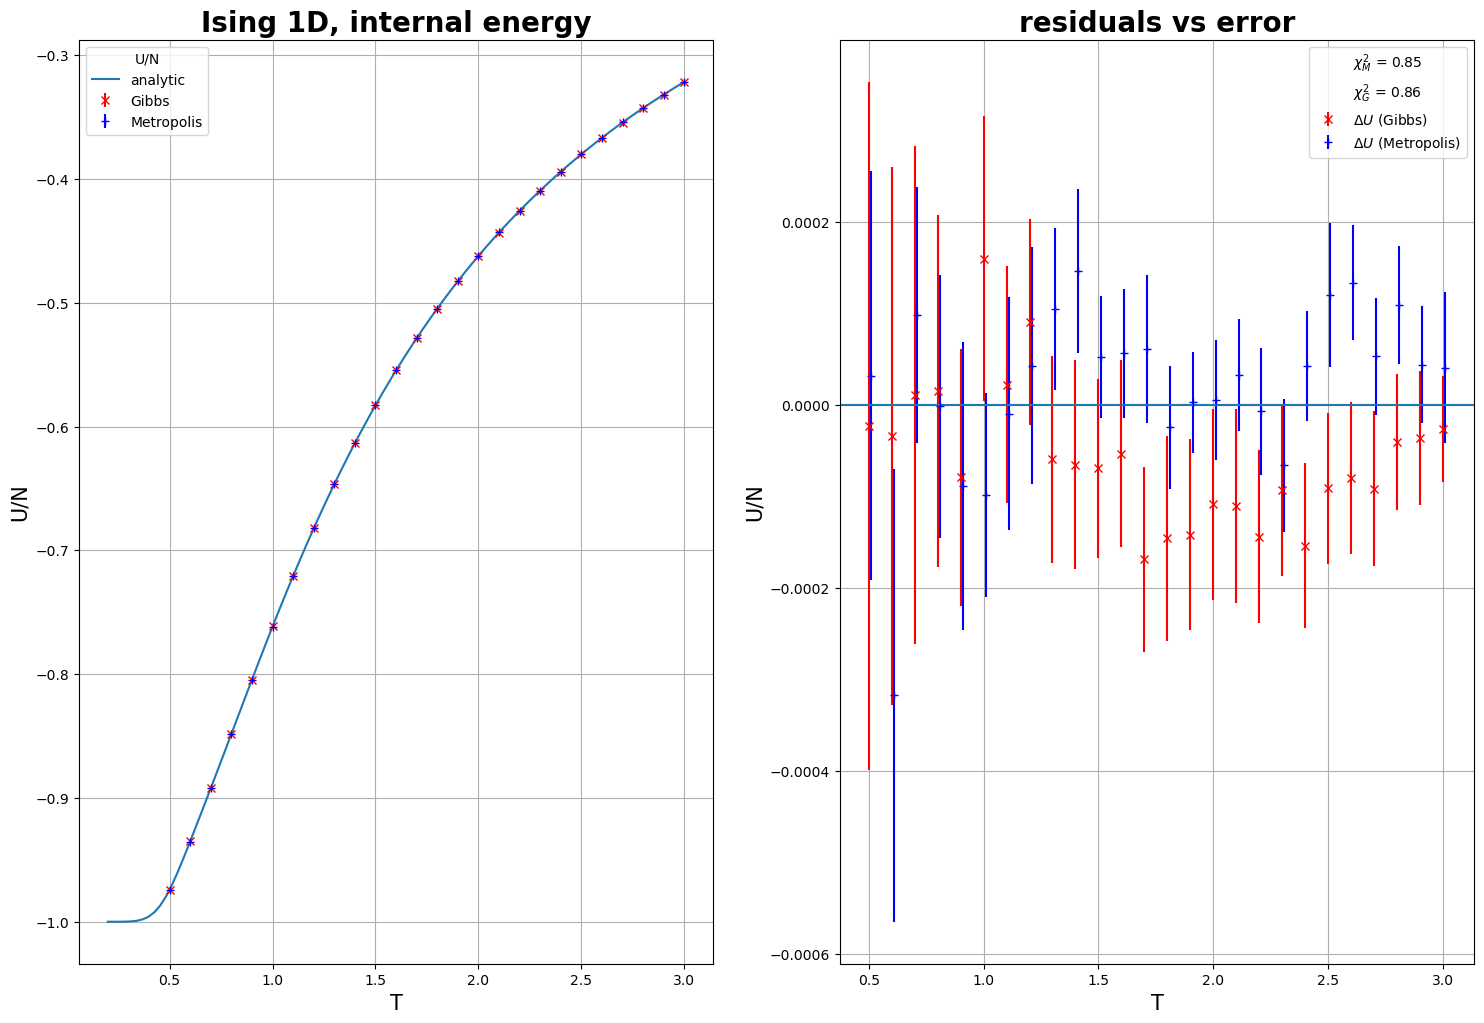

In [15]:
# internal energy
points=100

plt.figure(figsize = (18,12))
T = np.linspace(0.2,3.0,num=points)

plt.subplot(1,2,1)
plt.plot(T, U(T), label=r"analytic")
plt.title('Ising 1D, internal energy', fontsize = 20, fontweight = "bold")
plt.ylabel('U/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
temp, ave_fin, err = np.loadtxt("../DATA/Ising/GIBBS/total_energy.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin, yerr = err, marker='x', linestyle="none", label="Gibbs", color = "r")
temp, ave_fin_m, err_m = np.loadtxt("../DATA/Ising/Metropolis/total_energy.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin_m, yerr = err_m, marker='+', linestyle="none", label="Metropolis", color = "b")
plt.legend(title="U/N")
plt.grid()

temp = np.linspace(0.5,3.0,26) 
e_d = U(temp)

plt.subplot(1,2,2)
plt.errorbar(temp, ave_fin-e_d, yerr = err, marker='x', linestyle = " ", label="$\Delta U$ (Gibbs)", color = "r")
#+0.01 to better visualize the error
plt.errorbar(temp+0.01, ave_fin_m-e_d, yerr = err_m, marker='+', linestyle = " ", label="$\Delta U$ (Metropolis)", color = "b")
chi_m = (np.sum((ave_fin_m-e_d)**2/err_m**2))/ len(temp)
chi_b = (np.sum((ave_fin-e_d)**2/err**2))/ len(temp)
plt.plot([], [], ' ', label=r'$\chi^2_M$ = {:.2f}'.format(chi_m)) # Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label=r'$\chi^2_G$ = {:.2f}'.format(chi_b))
plt.title("residuals vs error", fontsize = 20, fontweight = "bold")
plt.ylabel('U/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
plt.legend()
plt.axhline(y=0)
plt.subplots_adjust(hspace=0.5)

#confidence level
print("Confidence level for Metropolis: ", '{:.3f}'.format(chi2_probability(chi_m, len(temp)))) 
print("Confidence level for Gibbs: ", '{:.3f}'.format(chi2_probability(chi_b, len(temp))))

plt.grid()
plt.show()



<a id="subsection-2-2"></a>
## Heat Capacity

- the **Heat Capacity** (with $h=0$):

$$
C(N,T) = \frac{\partial U(N,T)}{\partial T}
= \frac{\partial \beta}{\partial T}\frac{\partial U}{\partial \beta}
= -k_B\beta^2 \frac{\partial}{\partial \beta} \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z} \right] = \\
= -k_B\beta^2 \left[ -\sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \sum_{\{ s_i \}} H \exp \left( -\beta H\right)\frac{\partial Z^{-1}}{\partial \beta} \right] = \\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} + \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]\frac{1}{Z}\frac{\partial Z}{\partial \beta} \right\} =\\
= k_B\beta^2 \left\{ \sum_{\{ s_i \}} H^2 \frac{\exp \left( -\beta H\right)}{Z} - \left[ \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}\right]^2 \right\} =
k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)
$$

$$
\frac{C(N,T)}{N} = \frac{1}{N}\frac{\partial U(N,T)}{\partial T} =\\
\underset{h=0}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

Confidence level for Metropolis:  0.312
Confidence level for Gibbs:  0.992


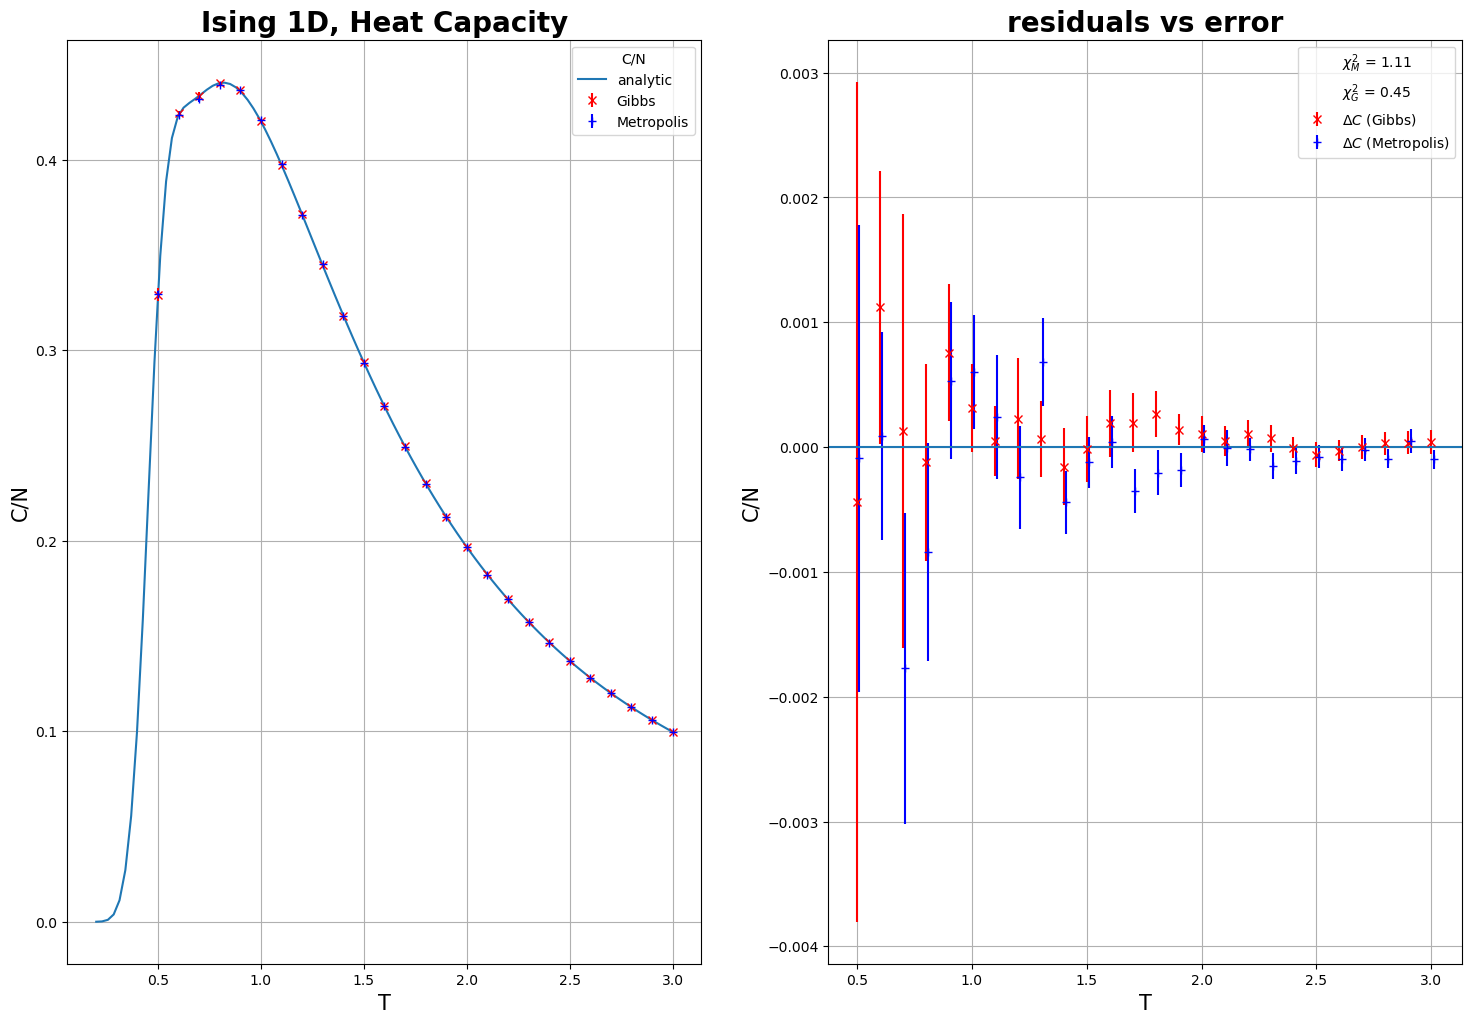

In [16]:
plt.figure(figsize = (18,12))

plt.subplot(1,2,1)
plt.plot(T, heat(T), label=r"analytic")
plt.title('Ising 1D, Heat Capacity', fontsize = 20, fontweight = "bold")
plt.ylabel('C/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
temp, ave_fin, err = np.loadtxt("../DATA/Ising/GIBBS/specific_heat.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin, yerr = err, marker='x', linestyle="none", label="Gibbs", color = "r")
temp, ave_fin_m, err_m = np.loadtxt("../DATA/Ising/Metropolis/specific_heat.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin_m, yerr = err_m, marker='+', linestyle="none", label="Metropolis", color = "b")
plt.legend(title="C/N")
plt.grid()

temp = np.linspace(0.5,3.0,26) 
e_d = heat(temp)

plt.subplot(1,2,2)
plt.errorbar(temp, ave_fin-e_d, yerr = err, marker='x', linestyle = " ", label="$\Delta C$ (Gibbs)", color = "r")
#+0.01 to avoid overlapping
plt.errorbar(temp+0.01, ave_fin_m-e_d, yerr = err_m, marker='+', linestyle = " ", label="$\Delta C$ (Metropolis)", color = "b")
chi_m = (np.sum((ave_fin_m-e_d)**2/err_m**2))/ len(temp)
chi_b = (np.sum((ave_fin-e_d)**2/err**2))/ len(temp)
plt.plot([], [], ' ', label=r'$\chi^2_M$ = {:.2f}'.format(chi_m)) # Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label=r'$\chi^2_G$ = {:.2f}'.format(chi_b))
plt.title("residuals vs error", fontsize = 20, fontweight = "bold")
plt.ylabel('C/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
plt.legend()
plt.axhline(y=0)
plt.subplots_adjust(hspace=0.5)

#confidence level
print("Confidence level for Metropolis: ", '{:.3f}'.format(chi2_probability(chi_m, len(temp)))) 
print("Confidence level for Gibbs: ", '{:.3f}'.format(chi2_probability(chi_b, len(temp))))

plt.grid()
plt.show()

<a id="subsection-2-3"></a>
## Magnetization

- The **magnetization** (with $h \not= 0$):

Note that with $h=0$ the magnetization $M(N,T,h=0)=\langle \sum_{i=1,N}s_i \rangle =0$ because in 1D we cannot have a (ferromagnetic) phase transition in absence of an external magnetic field.

$$
M(N,T,h) = -\frac{\partial A}{\partial h} = k_B T \frac{\partial \ln Z}{\partial h} =
\frac{1}{\beta} \frac{1}{Z}\frac{\partial}{\partial h}\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} = \left\langle \sum_{i=1,N}s_i \right\rangle
$$

The exact formula from $M(N,T,h) = k_B T \dfrac{\partial \ln Z}{\partial h}$ is:
$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$

Confidence level for Metropolis h= 0.02:  0.468
Confidence level for Gibbs h = 0.02:  0.659


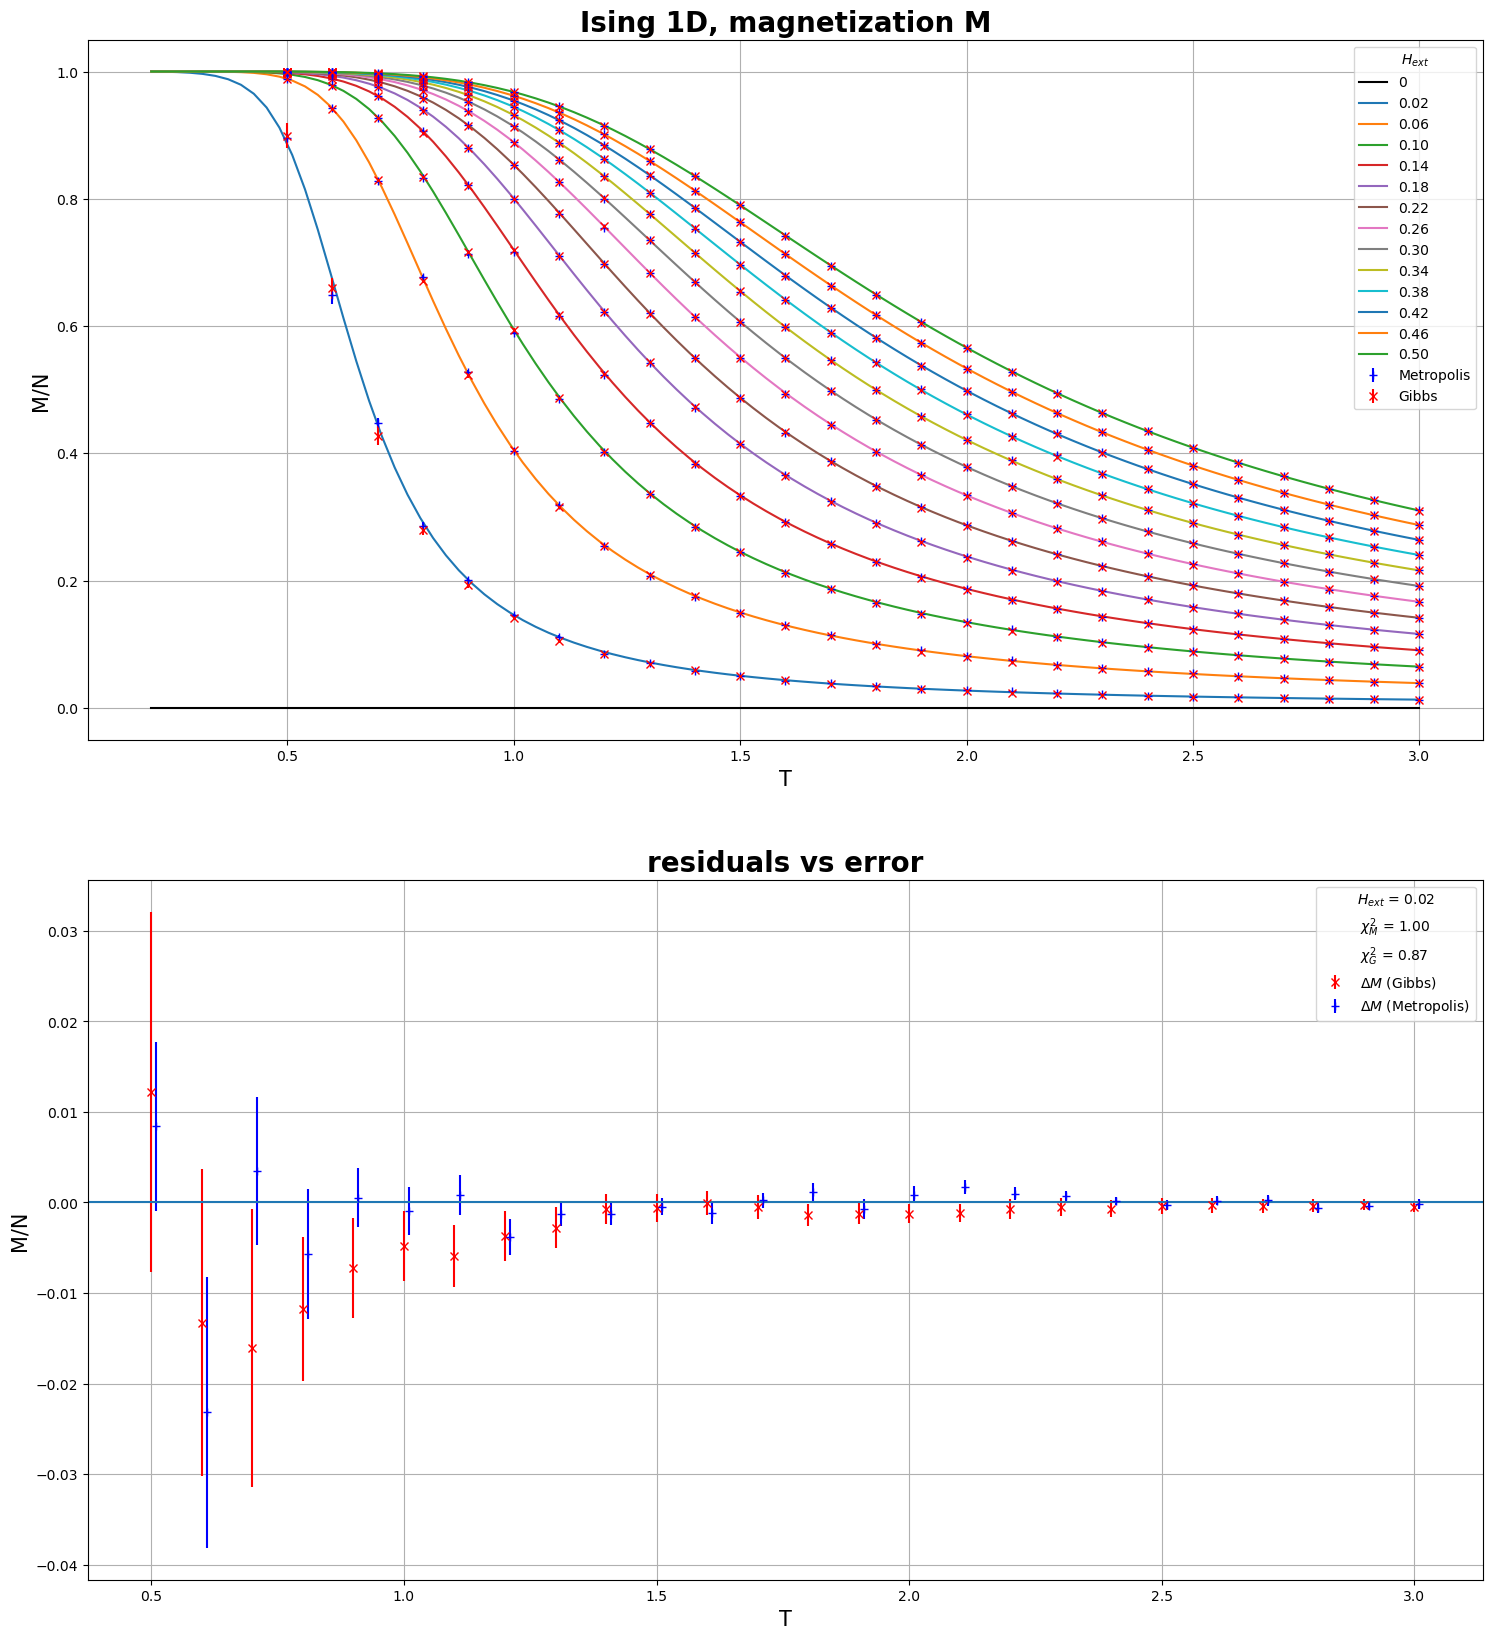

In [30]:
# h=0.02 #external field
h = np.linspace(0.02,0.5,13)

plt.figure(figsize = (18,20)) # size of the plot (width, height)

plt.subplot(2,1,1) # 2 rows, 1 column, 1st plot
plt.plot(T,M(T,0),label='0',color='black')

# Initialize arrays to store Metropolis data for each h
ave_fin = []
err = []
ave_fin_m = []
err_m = []

for n,i in enumerate(h): # n = index, i = value
    name = "{:.2f}".format(i)
    plt.plot(T, M(T,i),label=str("{:.2f}".format(i)))
    temp, ave_m, err_m_ = np.loadtxt(f"../DATA/Ising/Metropolis/magnetization{name}.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
    temp, ave_g, err_g = np.loadtxt(f"../DATA/Ising/GIBBS/magnetization{name}.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
    ave_fin_m.append(ave_m)
    err_m.append(err_m_)
    ave_fin.append(ave_g)
    err.append(err_g)
    if n == 0:
        plt.errorbar(temp, ave_fin_m[n], yerr = err_m[n], marker='+', linestyle="none", label="Metropolis", color = "b")
        plt.errorbar(temp, ave_fin[n], yerr = err[n], marker='x', linestyle="none", label="Gibbs", color = "r")
    else:
        plt.errorbar(temp, ave_fin_m[n], yerr = err_m[n], marker='+', linestyle="none", color = "b")
        plt.errorbar(temp, ave_fin[n], yerr = err[n], marker='x', linestyle="none", color = "r")

plt.title('Ising 1D, magnetization M', fontsize = 20, fontweight = "bold")
plt.ylabel('M/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
plt.legend(title=r'$H_{ext}$')
plt.grid()

temp = np.linspace(0.5,3.0,26) 


# for n,i in enumerate(h): # n = index, i = value # the Chi2 test is not good for other values of h, needs more steps
n = 0
i = 0.02
e_d = M(temp,i)
plt.subplot(2,1,2)
plt.errorbar(temp, ave_fin[n]-e_d, yerr = err[n], marker='x', linestyle = " ", label="$\Delta M$ (Gibbs)", color = "r")
#+0.01 to avoid overlapping
plt.errorbar(temp+0.01, ave_fin_m[n]-e_d, yerr = err_m[n], marker='+', linestyle = " ", label="$\Delta M$ (Metropolis)", color = "b")
chi_m = (np.sum((ave_fin_m[n]-e_d)**2/err_m[n]**2))/ len(temp)
chi_b = (np.sum((ave_fin[n]-e_d)**2/err[n]**2))/ len(temp)
plt.plot([], [], ' ', label='$\chi^2_M$ = {:.2f}'.format(chi_m)) # Create empty plot with blank marker containing the extra label
plt.plot([],[],' ',label='$\chi^2_G$ = {:.2f}'.format(chi_b))
plt.title("residuals vs error", fontsize = 20, fontweight = "bold")
plt.ylabel('M/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)

name = "{:.2f}".format(i)
plt.legend(title = "$H_{ext}$ = "+ f"{name}")
plt.axhline(y=0)
plt.subplots_adjust(hspace=0.2)
#confidence level
print(f"Confidence level for Metropolis h= {name}: ", '{:.3f}'.format(chi2_probability(chi_m, len(temp)))) 
print(f"Confidence level for Gibbs h = {name}: ", '{:.3f}'.format(chi2_probability(chi_b, len(temp))))

plt.grid()
plt.show()

<a id="subsection-2-4"></a>
## Magnetic Susceptibility

- The **magnetic susceptibility** (with $h=0$):

$$
\chi(N,T) = \frac{\partial M}{\partial h} = 
\frac{\partial}{\partial h}\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z} =\\
= \beta\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right]^2 \frac{\exp \left( -\beta H\right)}{Z}
-\sum_{\{ s_i \}} \left[ \sum_{i=1,N}s_i\right] \frac{\exp \left( -\beta H\right)}{Z}
\frac{1}{Z}\frac{\partial Z}{\partial h} = 
\beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] = \\
\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

Confidence level for Metropolis:  0.568
Confidence level for Gibbs:  0.983


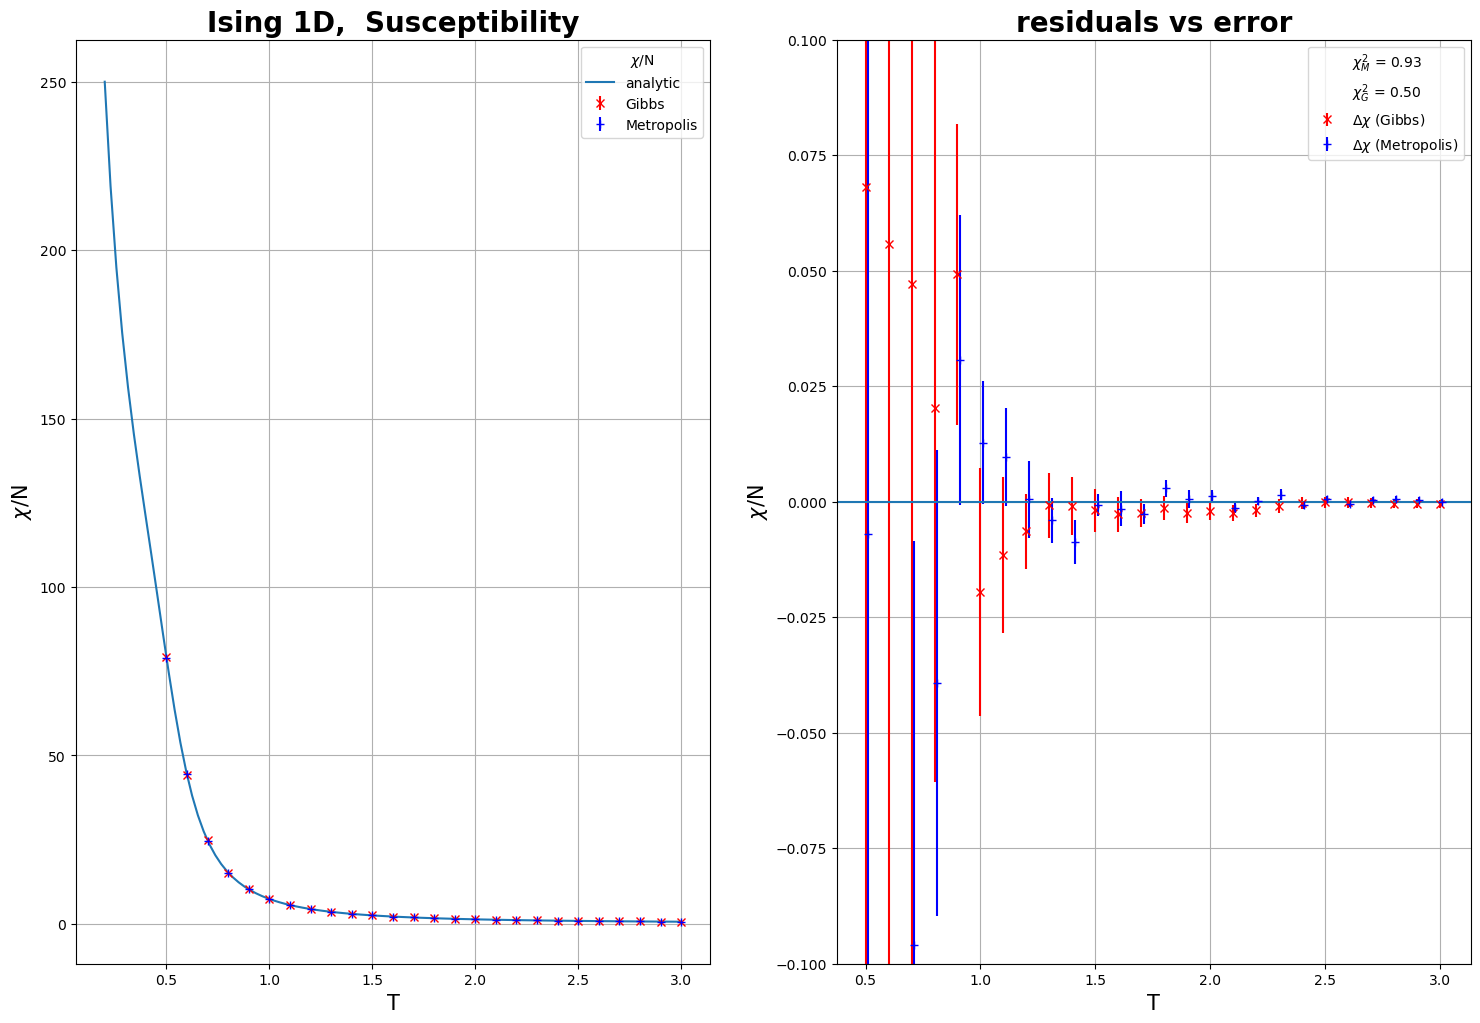

In [18]:
plt.figure(figsize = (18,12))

plt.subplot(1,2,1)
plt.plot(T, X(T), label=r"analytic")
plt.title('Ising 1D,  Susceptibility', fontsize = 20, fontweight = "bold")
plt.ylabel('$\chi$/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
temp, ave_fin, err = np.loadtxt("../DATA/Ising/GIBBS/susceptibility.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin, yerr = err, marker='x', linestyle="none", label="Gibbs", color = "r")
temp, ave_fin_m, err_m = np.loadtxt("../DATA/Ising/Metropolis/susceptibility.dat", usecols=(0,2,3), delimiter='\t', unpack='true')
plt.errorbar(temp, ave_fin_m, yerr = err_m, marker='+', linestyle="none", label="Metropolis", color = "b")
plt.legend(title="$\chi$/N")
plt.grid()

temp = np.linspace(0.5,3.0,26) 
e_d = X(temp)

plt.subplot(1,2,2)
plt.errorbar(temp, ave_fin-e_d, yerr = err, marker='x', linestyle = " ", label="$\Delta \chi$ (Gibbs)", color = "r")
#+0.01 to avoid overlapping
plt.errorbar(temp+0.01, ave_fin_m-e_d, yerr = err_m, marker='+', linestyle = " ", label="$\Delta \chi$ (Metropolis)", color = "b")
chi_m = (np.sum((ave_fin_m-e_d)**2/err_m**2))/ len(temp)
chi_b = (np.sum((ave_fin-e_d)**2/err**2))/ len(temp)
plt.plot([], [], ' ', label=r'$\chi^2_M$ = {:.2f}'.format(chi_m)) # Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label=r'$\chi^2_G$ = {:.2f}'.format(chi_b))
plt.title("residuals vs error", fontsize = 20, fontweight = "bold")
plt.ylabel('$\chi$/N',  fontsize = 15)
plt.xlabel('T',  fontsize = 15)
plt.ylim(-0.1,0.1)
plt.legend()
plt.axhline(y=0)
plt.subplots_adjust(hspace=0.5)

#confidence level
print("Confidence level for Metropolis: ", '{:.3f}'.format(chi2_probability(chi_m, len(temp)))) 
print("Confidence level for Gibbs: ", '{:.3f}'.format(chi2_probability(chi_b, len(temp))))

plt.grid()
plt.show()